In [1]:
# Modules
import xml.etree.ElementTree as ET
import random
import os
import glob
import pandas as pd
import tarfile
import nltk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

In [2]:
%load_ext autoreload
%autoreload 2

In [7]:
# Local
import parsing_xml as px
import peep_tar as peep

In [8]:
with tarfile.open('data/9203_001.tar.gz') as tfile:
    print(peep.article_name_dict(tfile))

FileNotFoundError: [Errno 2] No such file or directory: 'data/9203_001.tar.gz'

In [ ]:
for name,f in peep.tar_iter('/mnt/promath/math07/0704_001.tar.gz', '.xml'):
    print(name,'\n')
    try:
        dd = px.DefinitionsXML(f, fname=name)
        print(dd.get_def_sample_text_with())
    except ValueError as ee:
        print("\n Probably empty article: %s \n"%name, ee) 


0704_001/0704.0002/sparsity-certifying.xml 

{'real': [], 'nondef': [' In this short section we present a new application for the special case of practical importance, _inline_math_, _inline_math_. As discussed in the introduction, Laman’s theorem _citation_ characterizes minimally rigid graphs as the _inline_math_-tight graphs. In recent work on slider pinning, developed after the current paper was submitted, we introduced the slider-pinning model of rigidity _citation_. Combinatorially, we model the bar-slider frameworks as simple graphs together with some loops placed on their vertices in such a way that there are no more than _inline_math_ loops per vertex, one of each color. ', ' In this section we prove the main theorems (Theorem and Theorem ), continuing the investigation of decompositions induced by pebble game constructions by studying the case where a minimum number of monochromatic cycles are created. The main idea, captured in Lemma and illustrated in Figure , is to avoid c

In [18]:
for f in peep.tar_iter('/mnt/promath/math92/9203_001.tar.gz', '.xml'):
    print(type(f))

<class 'tarfile.ExFileObject'>
<class 'tarfile.ExFileObject'>
<class 'tarfile.ExFileObject'>


In [4]:
exml = ET.parse('tests/latexmled_files/math.0407523.xml')
ns = {'latexml': 'http://dlmf.nist.gov/LaTeXML' }
para_lst = exml.findall('.//latexml:para', ns)
para_text = [px.recutext1(p) for p in para_lst]

In [16]:
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc).split() for doc in para_text] 

In [36]:
# Importing Gensim
import gensim
from gensim import corpora

# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(doc_clean)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

In [39]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=3, id2word = dictionary, passes=50)

In [40]:
for l in ldamodel.print_topics(num_topics=3, num_words=3):
    print(l)

(0, '0.023*"extension" + 0.023*"system" + 0.023*"coherent"')
(1, '0.022*"coherent" + 0.022*"system" + 0.018*"follows"')
(2, '0.034*"value" + 0.024*"suppose" + 0.023*"critical"')


### Title:
#### ON THE GEOMETRY OF MODULI SPACES OF COHERENT SYSTEMS ON ALGEBRAIC CURVES

In [35]:
#prepare the dataset
allData = pd.DataFrame()
with open('../2000_defs.txt','r') as f1:
    all_data_texts = f1.readlines()
all_data_labels = len(all_data_texts)*[1.0]
with open('../out_2000.txt', 'r') as f2:
    all_data_texts_rand = f2.readlines()
all_data_texts += all_data_texts_rand
all_data_labels += len(all_data_texts_rand)*[0.0]

# 1.0 will represent definitions is true 0.0 means it is false (not a definition)
allData['labels'] = all_data_labels
allData['texts'] = all_data_texts

In [36]:
train_x, test_x, train_y, test_y = model_selection.train_test_split(allData['texts'], allData['labels'])

In [67]:
train_x.head(25)

853     a triangulated category         is of finite t...
1868           proof. by the expression of , all the r...
255              let  be an open covering of m, with l...
451              suppose we are given control data  on...
752            the quantity  defined for a -tuple of c...
1195    consider the following attributes of a cell   ...
454              let  be a  function, let  be a -like ...
43      for             put                           ...
1982                                                   \n
169                    let  be a face of the triangula...
1477    torus action and localization formula   \mylab...
832               is said to be pseudoeffective, if th...
434     a subset           of a simplicial complex  ha...
1411    we consider a prime divisor           on  whic...
1693                                                   \n
936                                                    \n
552              the set of isomorphism classes of tri...
802     let   

In [37]:
count_vect = CountVectorizer(analyzer='word', tokenizer=nltk.word_tokenize, ngram_range=(1,2))
count_vect.fit(allData['texts'])
xtrain = count_vect.transform(train_x)
xtest = count_vect.transform(test_x)

In [38]:
clf = naive_bayes.MultinomialNB().fit(xtrain, train_y)
predictions = clf.predict(xtest)
print(metrics.classification_report(predictions,test_y))

             precision    recall  f1-score   support

        0.0       0.61      0.93      0.73       174
        1.0       0.95      0.68      0.79       327

avg / total       0.83      0.77      0.77       501



In [42]:
print(metrics.confusion_matrix(predictions,test_y))

[[20  3]
 [13 26]]


In [74]:
#get values where prediction and value is different
test_val = zip(test_y.keys(),test_y, predictions)
div = [t for t in test_val if t[1] < 0.5 and t[2] > 0.5 ]
for d in div:
    print(allData['texts'][d[0]])
    print(' -------------%s'%d[0])

         suppose that  holds with . then there exists a sequence of permissible monodial transforms  such that the following properties hold:                                                       (1)                                        holds.                                     (2)                                       all bad 2 points  satisfy ().                                     (3)                                       suppose that  is a curve which is r big at a 1 point. then there exists at most one 3 point  and  has a tangent direction at  distinct from those of  at . furthermore, if  is not r big, there exists only one 2 point . if  is the 2 curve containing , then  is not r-1 big or r small.                                   (4)                                       if  is a r small or r-1 big 2 curve containing a 2 point  such that  where  is a curve containing a 1 point and  is r big at , then  is r big.

 -------------1737
if         is an oriented cycle in  then for a

In [69]:
# find the lines where the predictions and test are different
differ = test_y[test_y != predictions] 

true_differ = differ[differ > 0.5]
for d in true_differ.keys():
    print(allData['texts'][d])
    print('------------------')

         suppose that  holds with . then there exists a sequence of permissible monodial transforms  such that the following properties hold:                                                       (1)                                        holds.                                     (2)                                       all bad 2 points  satisfy ().                                     (3)                                       suppose that  is a curve which is r big at a 1 point. then there exists at most one 3 point  and  has a tangent direction at  distinct from those of  at . furthermore, if  is not r big, there exists only one 2 point . if  is the 2 curve containing , then  is not r-1 big or r small.                                   (4)                                       if  is a r small or r-1 big 2 curve containing a 2 point  such that  where  is a curve containing a 1 point and  is r big at , then  is r big.

------------------
if         is an oriented cycle in  then for a

In [65]:
out_file = open('../random_para_2015.txt','a')
ns = {'latexml': 'http://dlmf.nist.gov/LaTeXML' }

def check_sanity(p):
    '''
    Input:
    p: element tree result of searching for para tags
    Checks:
    contains an ERROR tag 
    '''
    if p.findall('.//latexml:ERROR', ns):
        return False
    else:
        return True 

for f in glob.glob('/home/luis/media_home/math.AG/2015/*/*.xml'):
    try:
        exml = ET.parse(f)
        para_lst_nonrand = exml.findall('.//latexml:para',ns)
        para_lst = random.sample(para_lst_nonrand, 2)
        for p in para_lst:
            if check_sanity(p):
                out_file.write(f + ':::' + px.recutext1(p) + "\n")
            else:
                print('article %s has messed up para'%f)
    except ET.ParseError:
        pass
    except ValueError:
        print('article %s has few paragraphs'%f)
out_file.close()

article /mnt/math.AG/2000/math.0001007/math.0001007.xml has few paragraphs
article /mnt/math.AG/2000/math.0001067/math.0001067.xml has few paragraphs
article /mnt/math.AG/2000/math.0001147/math.0001147.xml has messed up para
article /mnt/math.AG/2000/math.0002083/math.0002083.xml has messed up para
article /mnt/math.AG/2000/math.0001181/math.0001181.xml has messed up para
article /mnt/math.AG/2000/math.0003028/degenfig.xml has few paragraphs
article /mnt/math.AG/2000/math.0004096/math.0004096.xml has few paragraphs
article /mnt/math.AG/2000/math.0009123/math.0009123.xml has messed up para
article /mnt/math.AG/2000/math.0003071/code.xml has few paragraphs
article /mnt/math.AG/2000/math.0003085/nemethi_szilard.xml has messed up para
article /mnt/math.AG/2000/math.0003090/math.0003090.xml has messed up para
article /mnt/math.AG/2000/math.0003090/math.0003090.xml has messed up para
article /mnt/math.AG/2000/math.0003104/bnrel.xml has messed up para
article /mnt/math.AG/2000/math.0003138/ma

In [57]:
# checking for the words being stuck bug
f = "../math.0004134/f-4s-nc.xml"
#f = "tests/latexmled_files/math.0402243.xml"
ns = {'latexml': 'http://dlmf.nist.gov/LaTeXML' }
exml = ET.parse(f)
para_lst = exml.findall('.//latexml:para',ns)
[px.recutext1(p) for p in para_lst]

['                                                    \\eightrm             \\eightrm             \\eightrm             \\eightrm             \\eightrm             \\eightrm             \\eightrm             \\eightrm             \\eightrm             \\eightrm             \\eightrm             \\eightrm             \\eightrm             \\eightrm             \\eightrm             \\eightrm             \\eightrm           \\eightrm                                     \\eightrm0             \\eightrm             \\eightrm             \\eightrm             \\eightrm             \\eightrm             \\eightrm             \\eightrm             \\eightrm             \\eightrm             \\eightrm             \\eightrm             \\eightrm             \\eightrm             \\eightrm             \\eightrm             \\eightrm             \\eightrm           \\eightrm                                     \\eightrm1             \\eightrm             \\eightrm             \\eightrm           

In [62]:
el = para_lst[0]
el.findall('.//latexml:ERROR', ns)

[<Element '{http://dlmf.nist.gov/LaTeXML}ERROR' at 0x7fdeb1761bd8>,
 <Element '{http://dlmf.nist.gov/LaTeXML}ERROR' at 0x7fdeb1761818>,
 <Element '{http://dlmf.nist.gov/LaTeXML}ERROR' at 0x7fdeb1761368>,
 <Element '{http://dlmf.nist.gov/LaTeXML}ERROR' at 0x7fdeb1761138>,
 <Element '{http://dlmf.nist.gov/LaTeXML}ERROR' at 0x7fdeb1761098>,
 <Element '{http://dlmf.nist.gov/LaTeXML}ERROR' at 0x7fdeb175ae08>,
 <Element '{http://dlmf.nist.gov/LaTeXML}ERROR' at 0x7fdeb175acc8>,
 <Element '{http://dlmf.nist.gov/LaTeXML}ERROR' at 0x7fdeb175ab38>,
 <Element '{http://dlmf.nist.gov/LaTeXML}ERROR' at 0x7fdeb175a8b8>,
 <Element '{http://dlmf.nist.gov/LaTeXML}ERROR' at 0x7fdeb175a6d8>,
 <Element '{http://dlmf.nist.gov/LaTeXML}ERROR' at 0x7fdeb175a548>,
 <Element '{http://dlmf.nist.gov/LaTeXML}ERROR' at 0x7fdeb175a3b8>,
 <Element '{http://dlmf.nist.gov/LaTeXML}ERROR' at 0x7fdeb175a228>,
 <Element '{http://dlmf.nist.gov/LaTeXML}ERROR' at 0x7fdeb175a0e8>,
 <Element '{http://dlmf.nist.gov/LaTeXML}ERROR' 

In [58]:
len(para_lst)

3

In [25]:
def count_words_per_line(file_path):
    with open(file_path, 'r') as defs_file:
        def_lines = defs_file.readlines()
    len_lst = [len(l.split()) for l in def_lines]
    return len_lst
len_lst = count_words_per_line('../out_2000.txt')

(array([285., 185., 152., 119.,  93.,  64.,  49.,  31.,  20.,  16.,   8.,
         10.,   7.,   4.,   4.]),
 array([  0.        ,  13.33333333,  26.66666667,  40.        ,
         53.33333333,  66.66666667,  80.        ,  93.33333333,
        106.66666667, 120.        , 133.33333333, 146.66666667,
        160.        , 173.33333333, 186.66666667, 200.        ]),
 <a list of 15 Patch objects>)

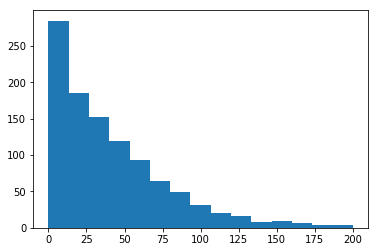

In [34]:
plt.hist(len_lst, range=(0,200), bins=15)

(array([132., 287., 202., 146.,  62.,  33.,  35.,  16.,   5.,   5.,   4.,
          2.,   3.,   0.,   1.]),
 array([  0.        ,  12.93333333,  25.86666667,  38.8       ,
         51.73333333,  64.66666667,  77.6       ,  90.53333333,
        103.46666667, 116.4       , 129.33333333, 142.26666667,
        155.2       , 168.13333333, 181.06666667, 194.        ]),
 <a list of 15 Patch objects>)

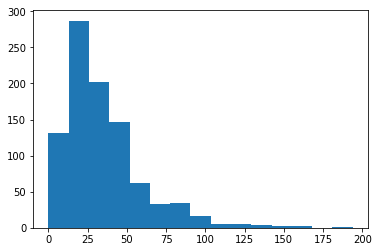

In [33]:
plt.hist(count_words_per_line('../2000_defs.txt'), bins=15)